## SIGNAL PROCESSING WITH GW150914 OPEN DATA

Gravitational waves are ripples in the curvature of spacetime that are generated in certain gravitational interactions and propagate as waves outward from their source at the speed of light. 

As a gravitational wave passes an observer, that observer will find spacetime distorted by the effects of strain. Distances between objects increase and decrease rhythmically as the wave passes, at a frequency corresponding to that of the wave.

In [1]:
# Standard python numerical analysis imports:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl

In [2]:
#----------------------------------------------------------------
# Load LIGO data from a single file
#----------------------------------------------------------------
# First from H1
#fn_H1 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
fn_H1 = 'H-H1_LOSC_4_V1-1126257414-4096.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
# and then from L1
#fn_L1 = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
fn_L1 = 'L-L1_LOSC_4_V1-1126257414-4096.hdf5'
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# sampling rate:
fs = 4096
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

In [3]:
# read in the NR template
NRtime, NR_H1 = np.genfromtxt('GW150914_4_NR_waveform.txt').transpose()

## First look at the data from H1 and L1

In [4]:
# First, let's look at the data and print out some stuff:

# this doesn't seem to work for scientific notation:
# np.set_printoptions(precision=4)

print('time_H1: len, min, mean, max = ', 
   len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max())
print('strain_H1: len, min, mean, max = ', 
   len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print('strain_L1: len, min, mean, max = ', 
   len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())
    
#What's in chan_dict? See https://losc.ligo.org/archive/dataset/GW150914/
bits = chan_dict_H1['DATA']
print('H1     DATA: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_H1['CBC_CAT1']
print('H1 CBC_CAT1: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_H1['CBC_CAT2']
print('H1 CBC_CAT2: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_L1['DATA']
print('L1     DATA: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_L1['CBC_CAT1']
print('L1 CBC_CAT1: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
bits = chan_dict_L1['CBC_CAT2']
print('L1 CBC_CAT2: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max())
print('In both H1 and L1, all 32 seconds of data are present (DATA=1), ')
print("and all pass data quality (CBC_CAT1=1 and CBC_CAT2=1).")

time_H1: len, min, mean, max =  16777216 1126257414.0 1126259462.0 1126261510.0
strain_H1: len, min, mean, max =  16777216 -4.71143131989e-18 -1.48142502938e-23 4.86896101297e-18
strain_L1: len, min, mean, max =  16777216 -4.74820965081e-18 -1.828544157e-18 6.60090553771e-19
H1     DATA: len, min, mean, max =  4096 1 1.0 1
H1 CBC_CAT1: len, min, mean, max =  4096 1 1.0 1
H1 CBC_CAT2: len, min, mean, max =  4096 1 1.0 1
L1     DATA: len, min, mean, max =  4096 1 1.0 1
L1 CBC_CAT1: len, min, mean, max =  4096 1 1.0 1
L1 CBC_CAT2: len, min, mean, max =  4096 1 1.0 1
In both H1 and L1, all 32 seconds of data are present (DATA=1), 
and all pass data quality (CBC_CAT1=1 and CBC_CAT2=1).


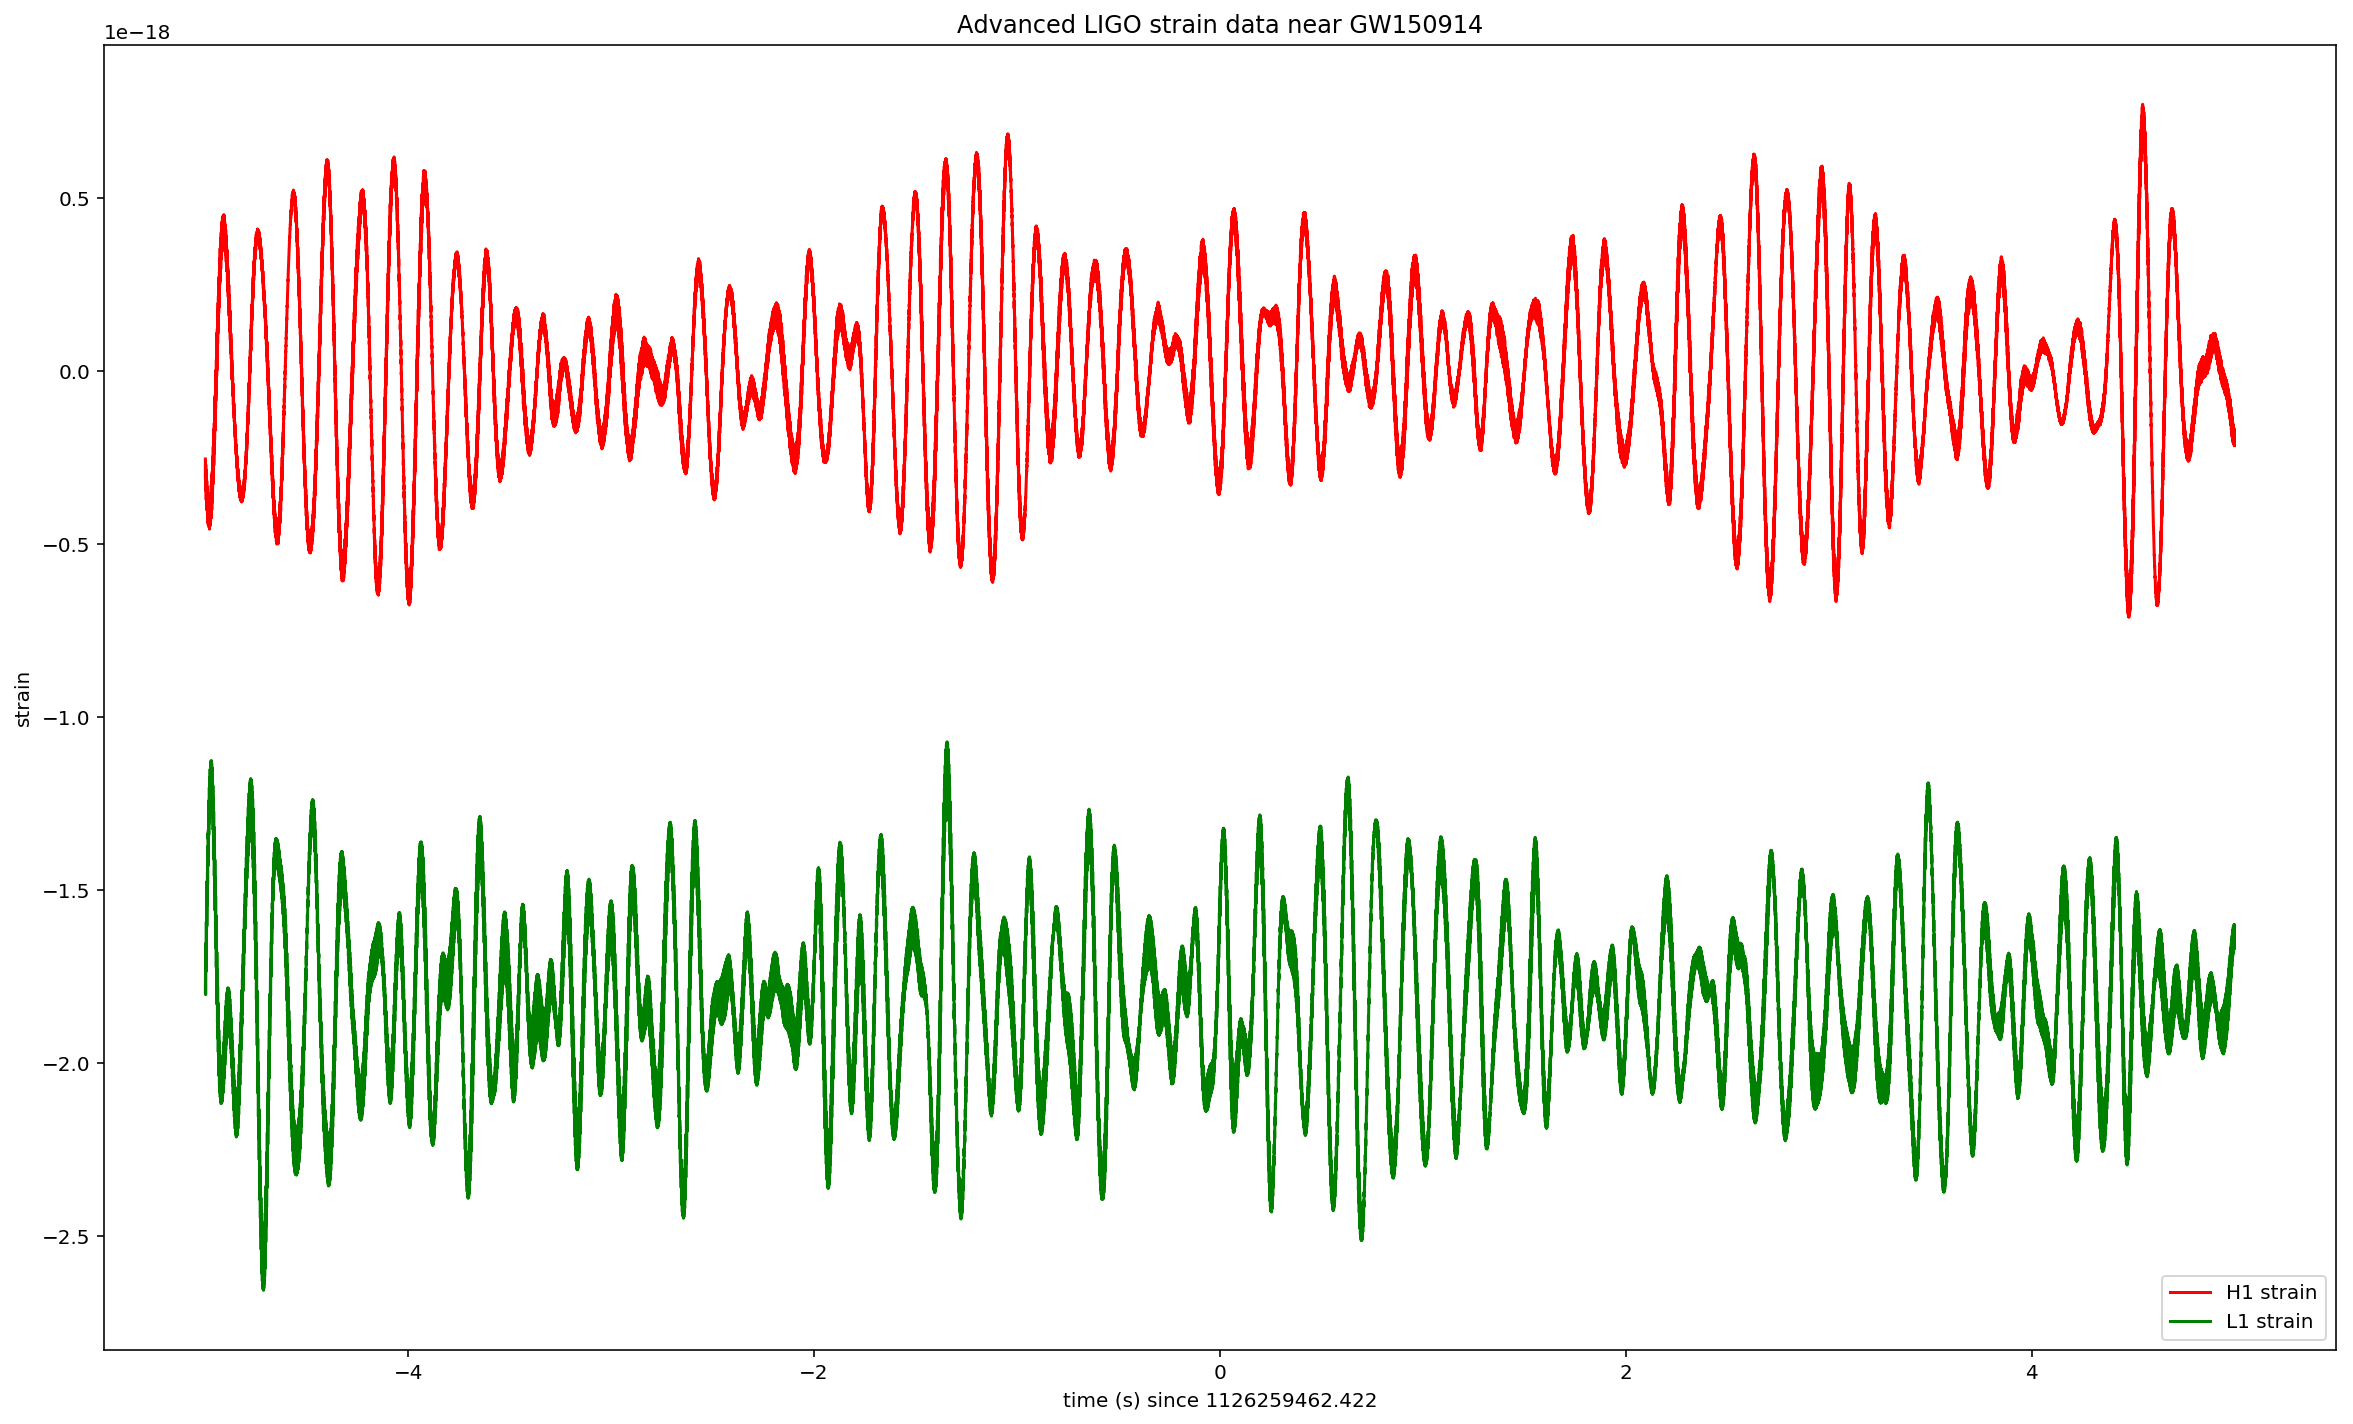

In [8]:
# plot +- 5 seconds around the event:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                     # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

plt.figure(figsize=(20,12))
plt.plot(time_H1[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time_L1[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near GW150914')
#plt.savefig('GW150914_strain.png')

In [80]:
S2.head()

,strain_H1,strain_L1,time,strain_H1_whiten,strain_H1_whitenbp,strain_L1_whiten,strain_L1_whitenbp
0,-9.823091e-20,-1.867281e-18,2015-09-14 09:16:54.000000,115.508182,-1.263464,232.176883,7.583278
1,-9.152205e-20,-1.873795e-18,2015-09-14 09:16:54.000244,151.317600,7.633869,253.797931,9.133790
2,-1.084111e-19,-1.916191e-18,2015-09-14 09:16:54.000488,144.783259,15.189218,196.272118,10.700582
3,-1.057191e-19,-1.955570e-18,2015-09-14 09:16:54.000732,137.372998,20.284173,119.687279,12.028879
4,-1.157184e-19,-1.964254e-18,2015-09-14 09:16:54.000977,136.057468,22.182133,86.961090,12.957294


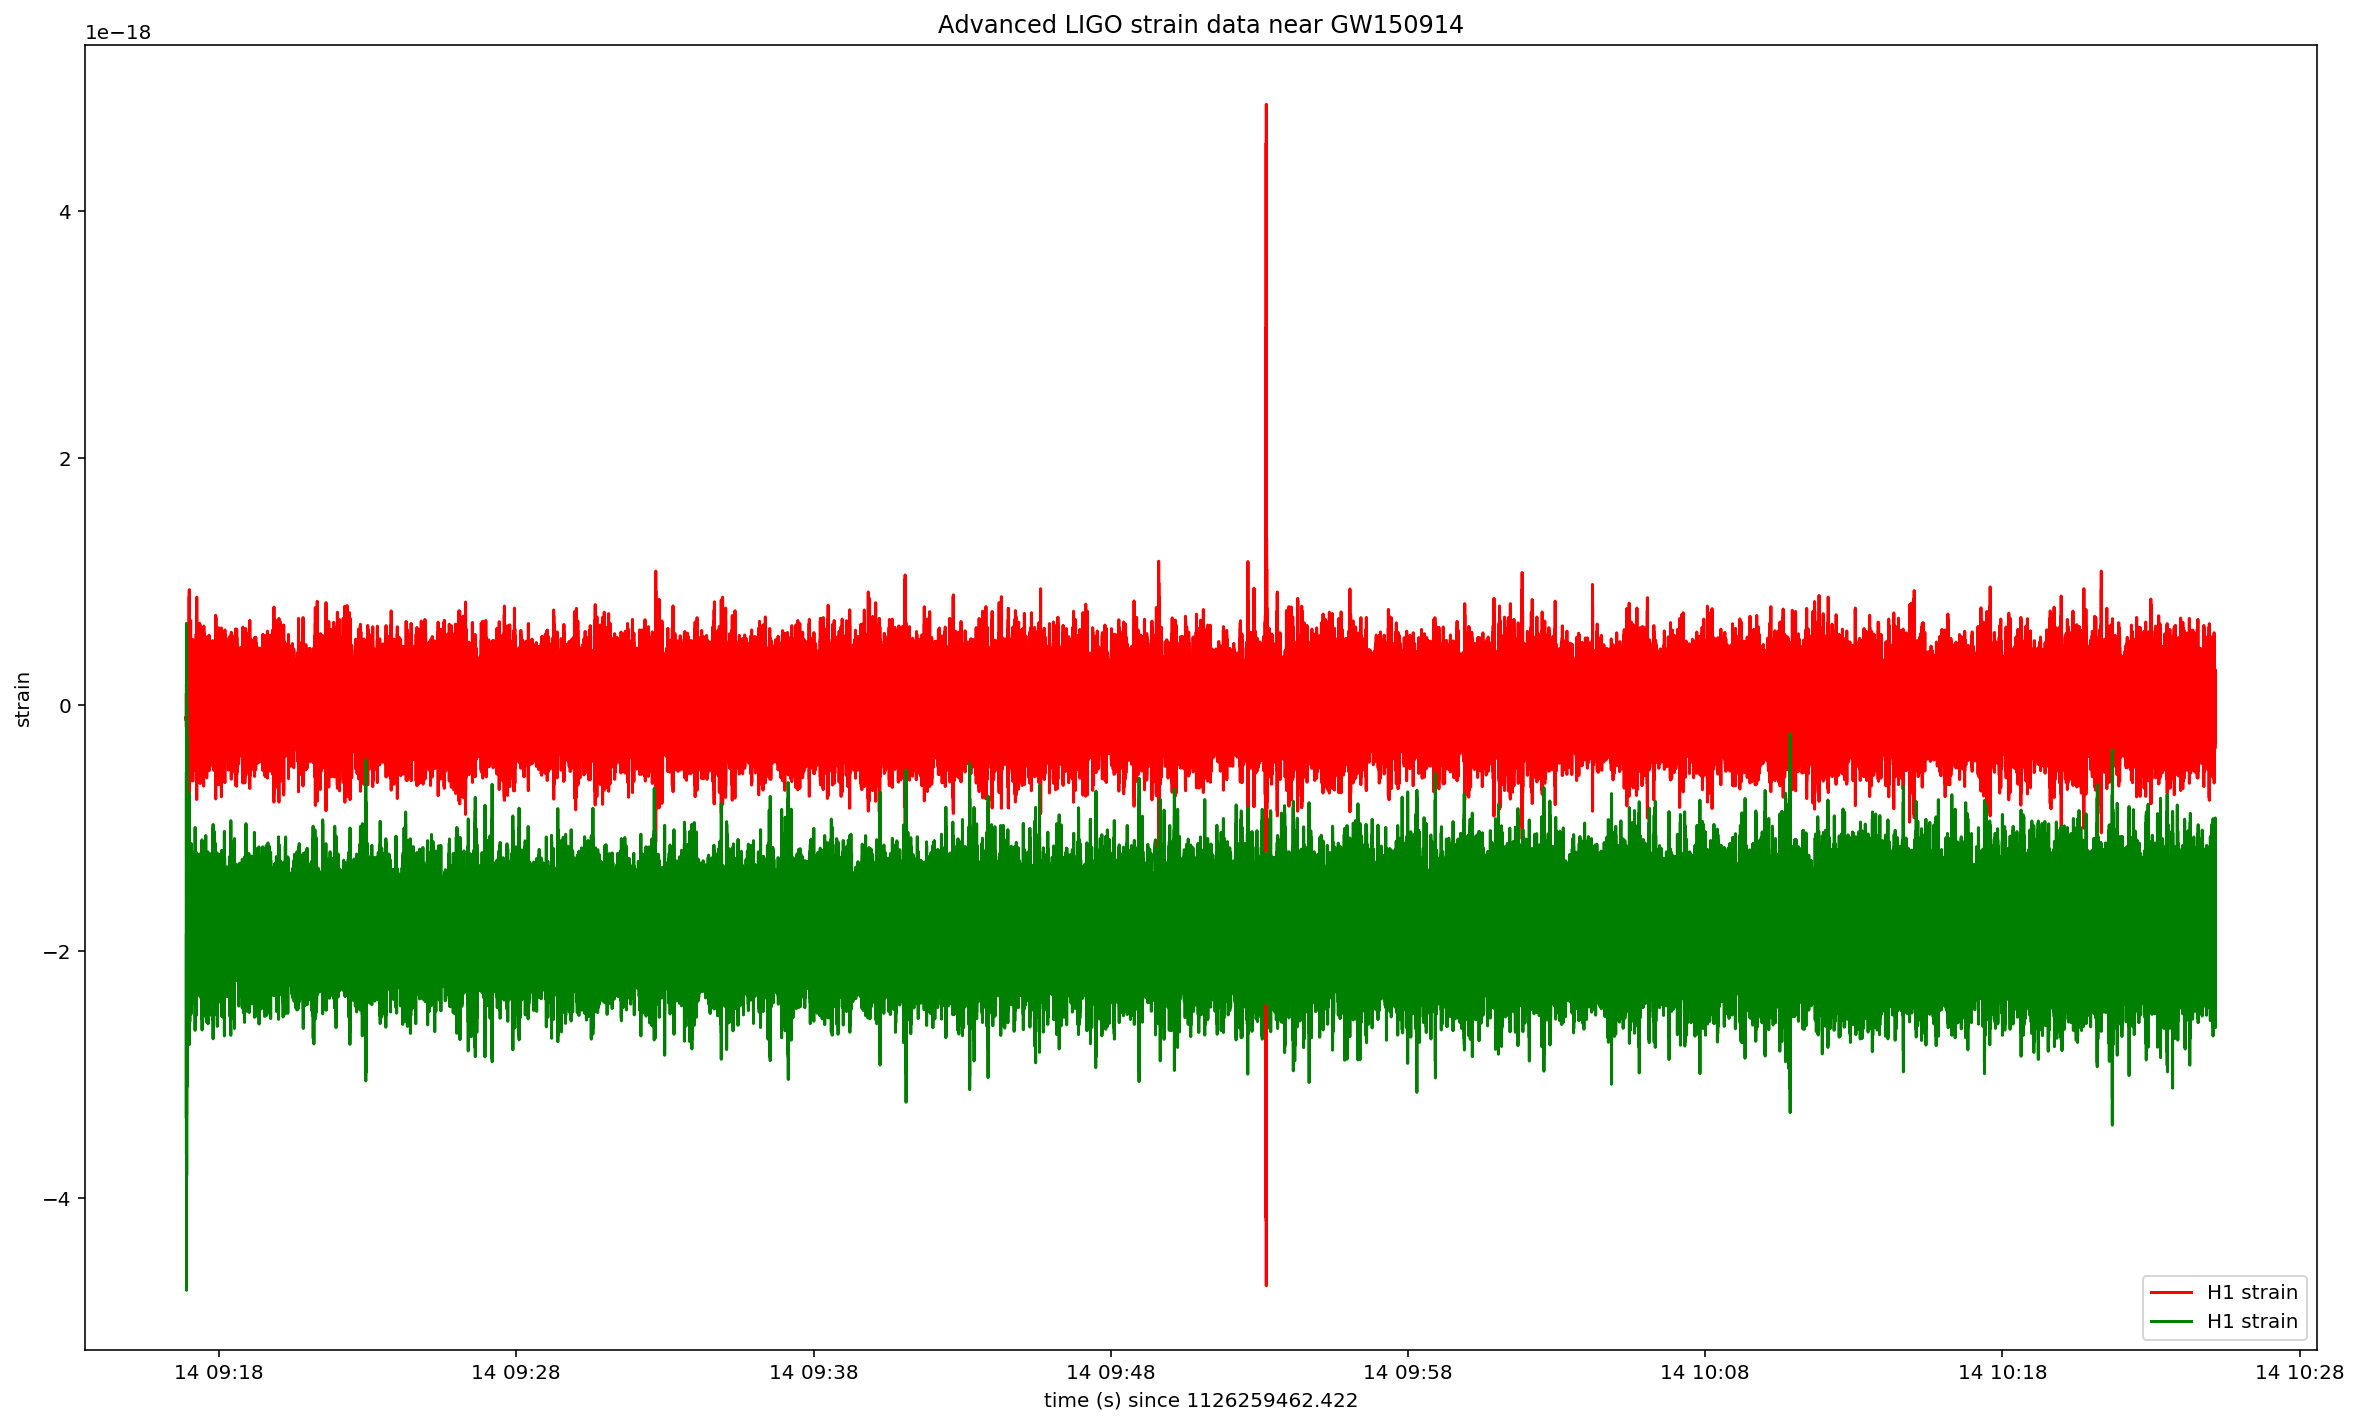

In [78]:
# plot +- 5 seconds around the event:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                     # seconds around the event
# index into the strain time series for this time interval:

plt.figure(figsize=(20,12))
plt.plot(S2['time'], S2['strain_H1'],'r',label='H1 strain')
plt.plot(S2['time'], S2['strain_L1'],'g',label='H1 strain')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near GW150914')
#plt.savefig('GW150914_strain.png')

## Data in the Fourier domain - ASDs

Plotting these data in the Fourier domain gives an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

$$PSD = \overline{FFT^2}$$

$$ASD = \sqrt{PSD}$$

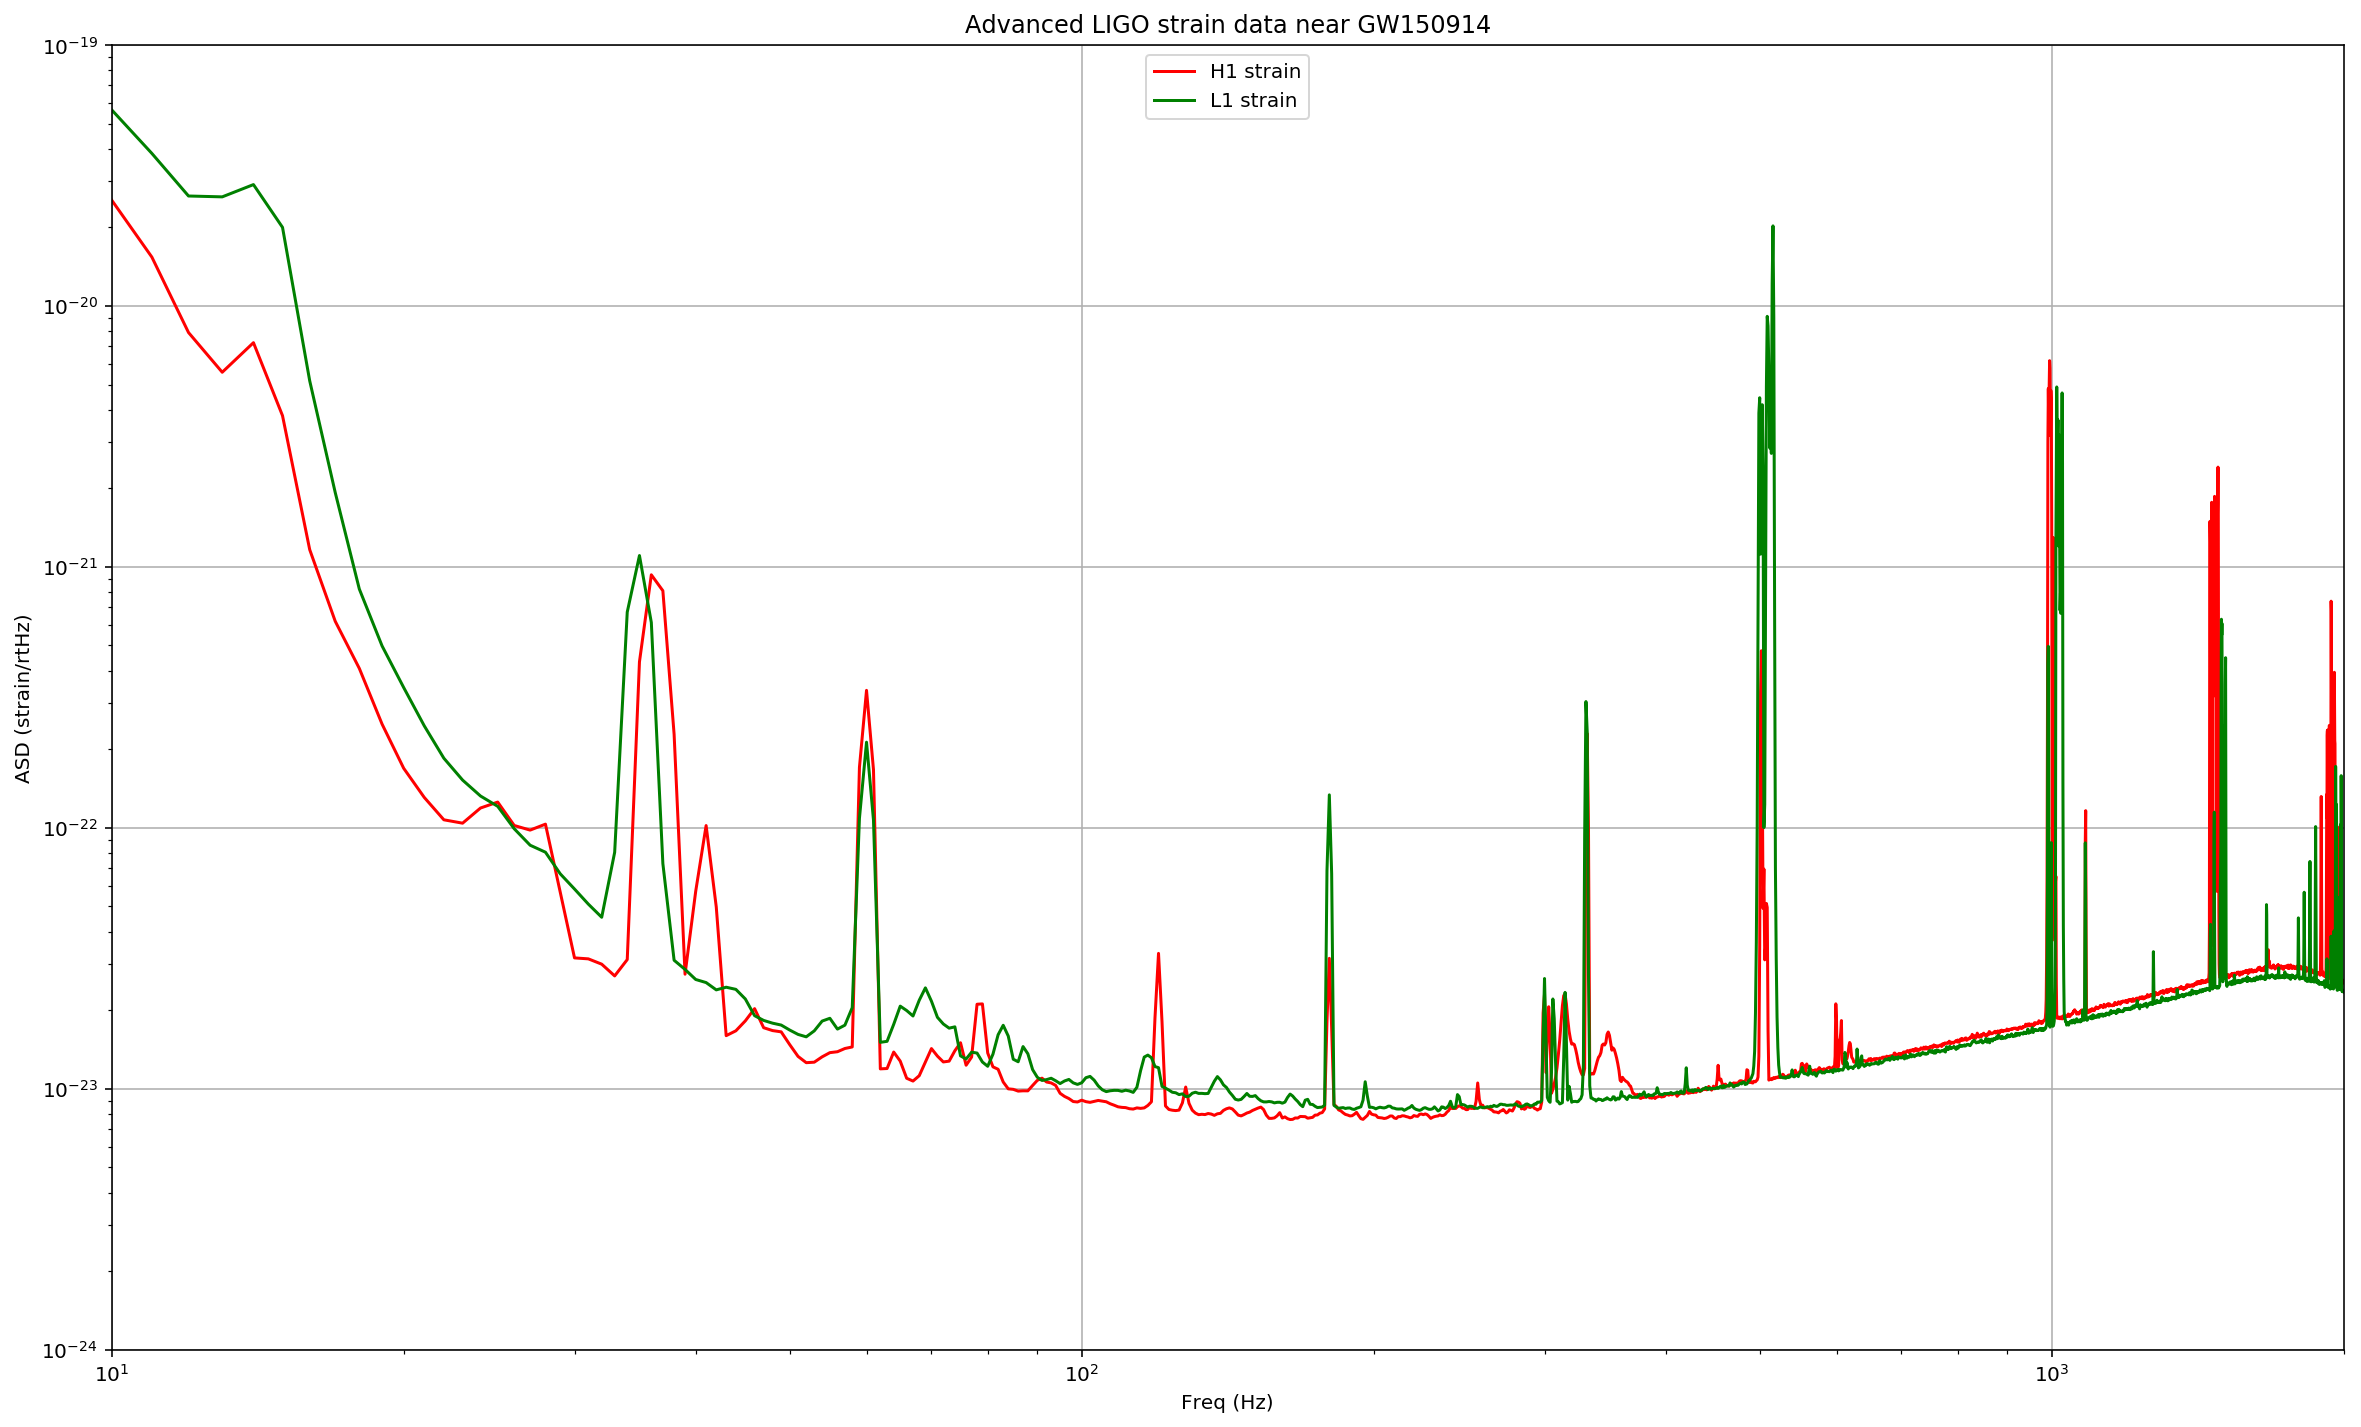

In [17]:
# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

# plot the ASDs:
plt.figure(figsize=(20,12))
plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_ASDs.png')

The frequencies below 10 are [DSP explanation]. The ASD (Amplitude Spectral Density) is based off the FFT. We are only interested in bands between 20-300Hz?

## Whitening

Can "whiten" the data (dividing it by the noise amplitude spectrum, in the fourier domain), suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band.

The resulting time series is no longer in units of strain; now in units of "sigmas" away from the mean.

In [19]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

# now whiten the data from H1 and L1, and also the NR template:
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
NR_H1_whiten = whiten(NR_H1,psd_H1,dt)

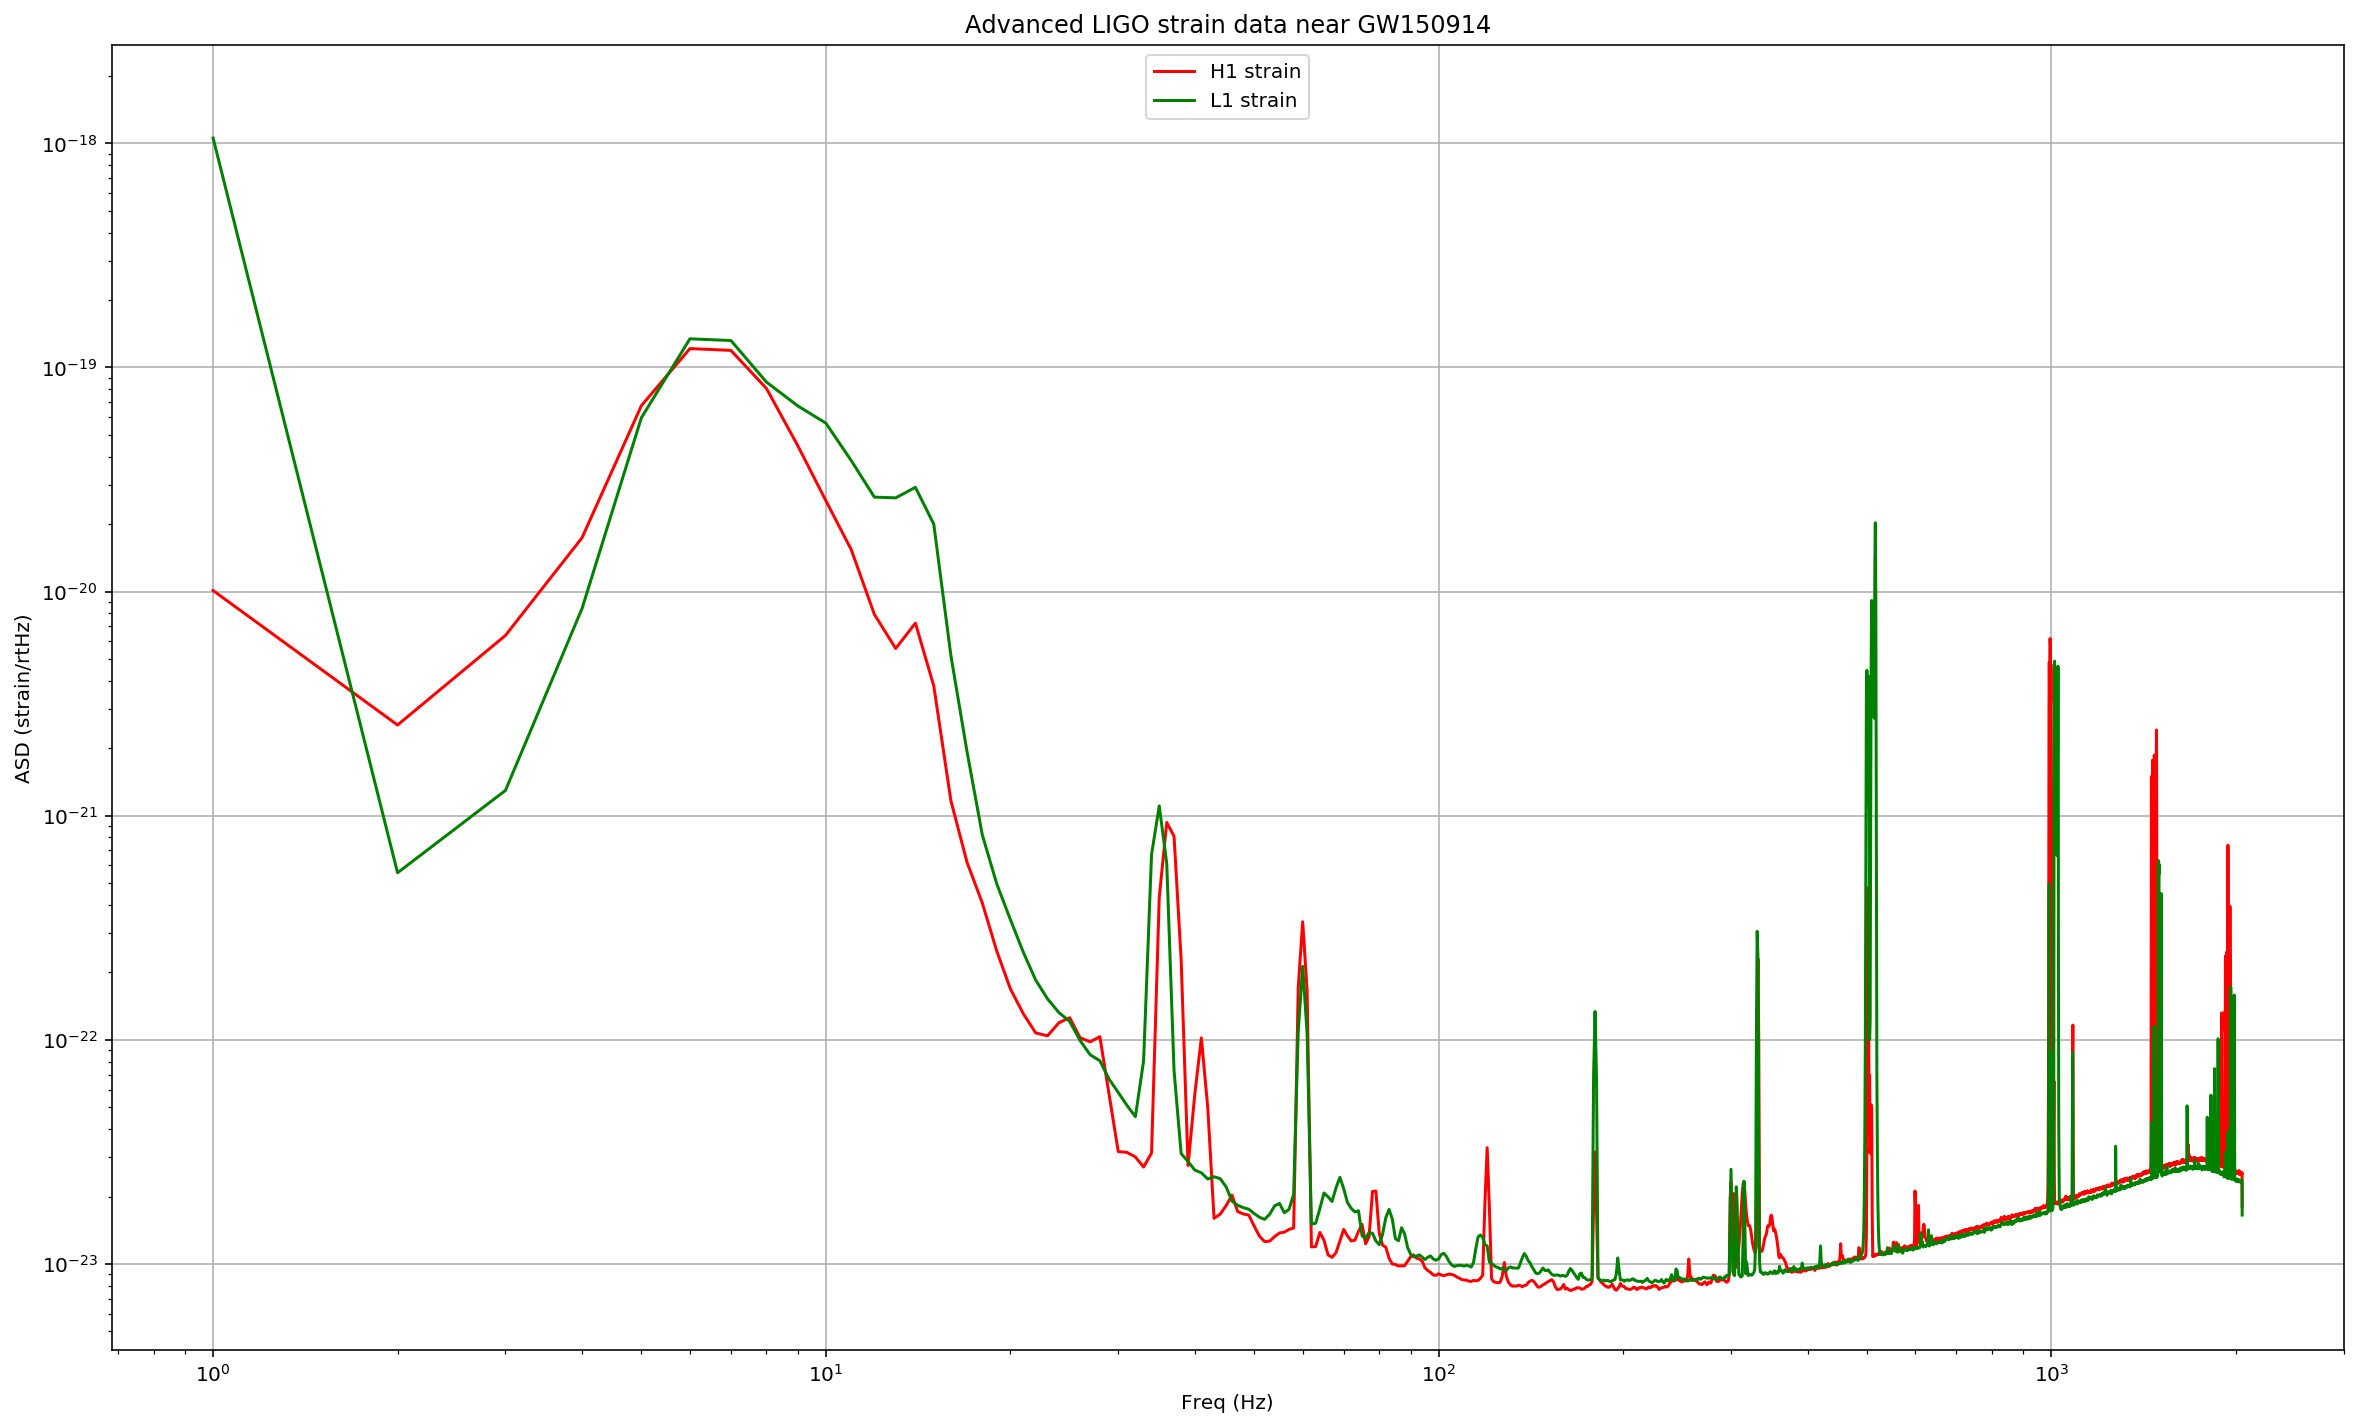

In [32]:
# plot the ASDs:
plt.figure(figsize=(20,12))
plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
#plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914 after whitening')
plt.savefig('GW150914_ASDs_whitened.png')

In [38]:
# We need to suppress the high frequencies with some bandpassing:
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)
NR_H1_whitenbp = filtfilt(bb, ab, NR_H1_whiten)

# plot the data after whitening:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

In [39]:
S2_whiten_dict = {'strain_L1_whiten': strain_L1_whiten, 'strain_H1_whiten': strain_H1_whiten, 'strain_H1_whitenbp': strain_H1_whitenbp, 'strain_L1_whitenbp': strain_L1_shift}
S2_whiten = pd.DataFrame(data=S2_whiten_dict)
S2 = pd.concat([S2, S2_whiten], axis=1)

In [40]:
S2.head()

,strain_H1,strain_L1,time,strain_H1_whiten,strain_H1_whitenbp,strain_L1_whiten,strain_L1_whitenbp
0,-9.823091e-20,-1.867281e-18,2015-09-14 09:16:54.000000,115.508182,-1.263464,232.176883,7.583278
1,-9.152205e-20,-1.873795e-18,2015-09-14 09:16:54.000244,151.317600,7.633869,253.797931,9.133790
2,-1.084111e-19,-1.916191e-18,2015-09-14 09:16:54.000488,144.783259,15.189218,196.272118,10.700582
3,-1.057191e-19,-1.955570e-18,2015-09-14 09:16:54.000732,137.372998,20.284173,119.687279,12.028879
4,-1.157184e-19,-1.964254e-18,2015-09-14 09:16:54.000977,136.057468,22.182133,86.961090,12.957294


In [69]:
tevent = pd.to_datetime(tevent, unit='s', origin=pd.Timestamp('1980-01-06'))

In [71]:
print("window", tevent-pd.Timedelta(seconds=5), tevent+pd.Timedelta(seconds=5))

window 2015-09-14 09:50:57.422000 2015-09-14 09:51:07.422000


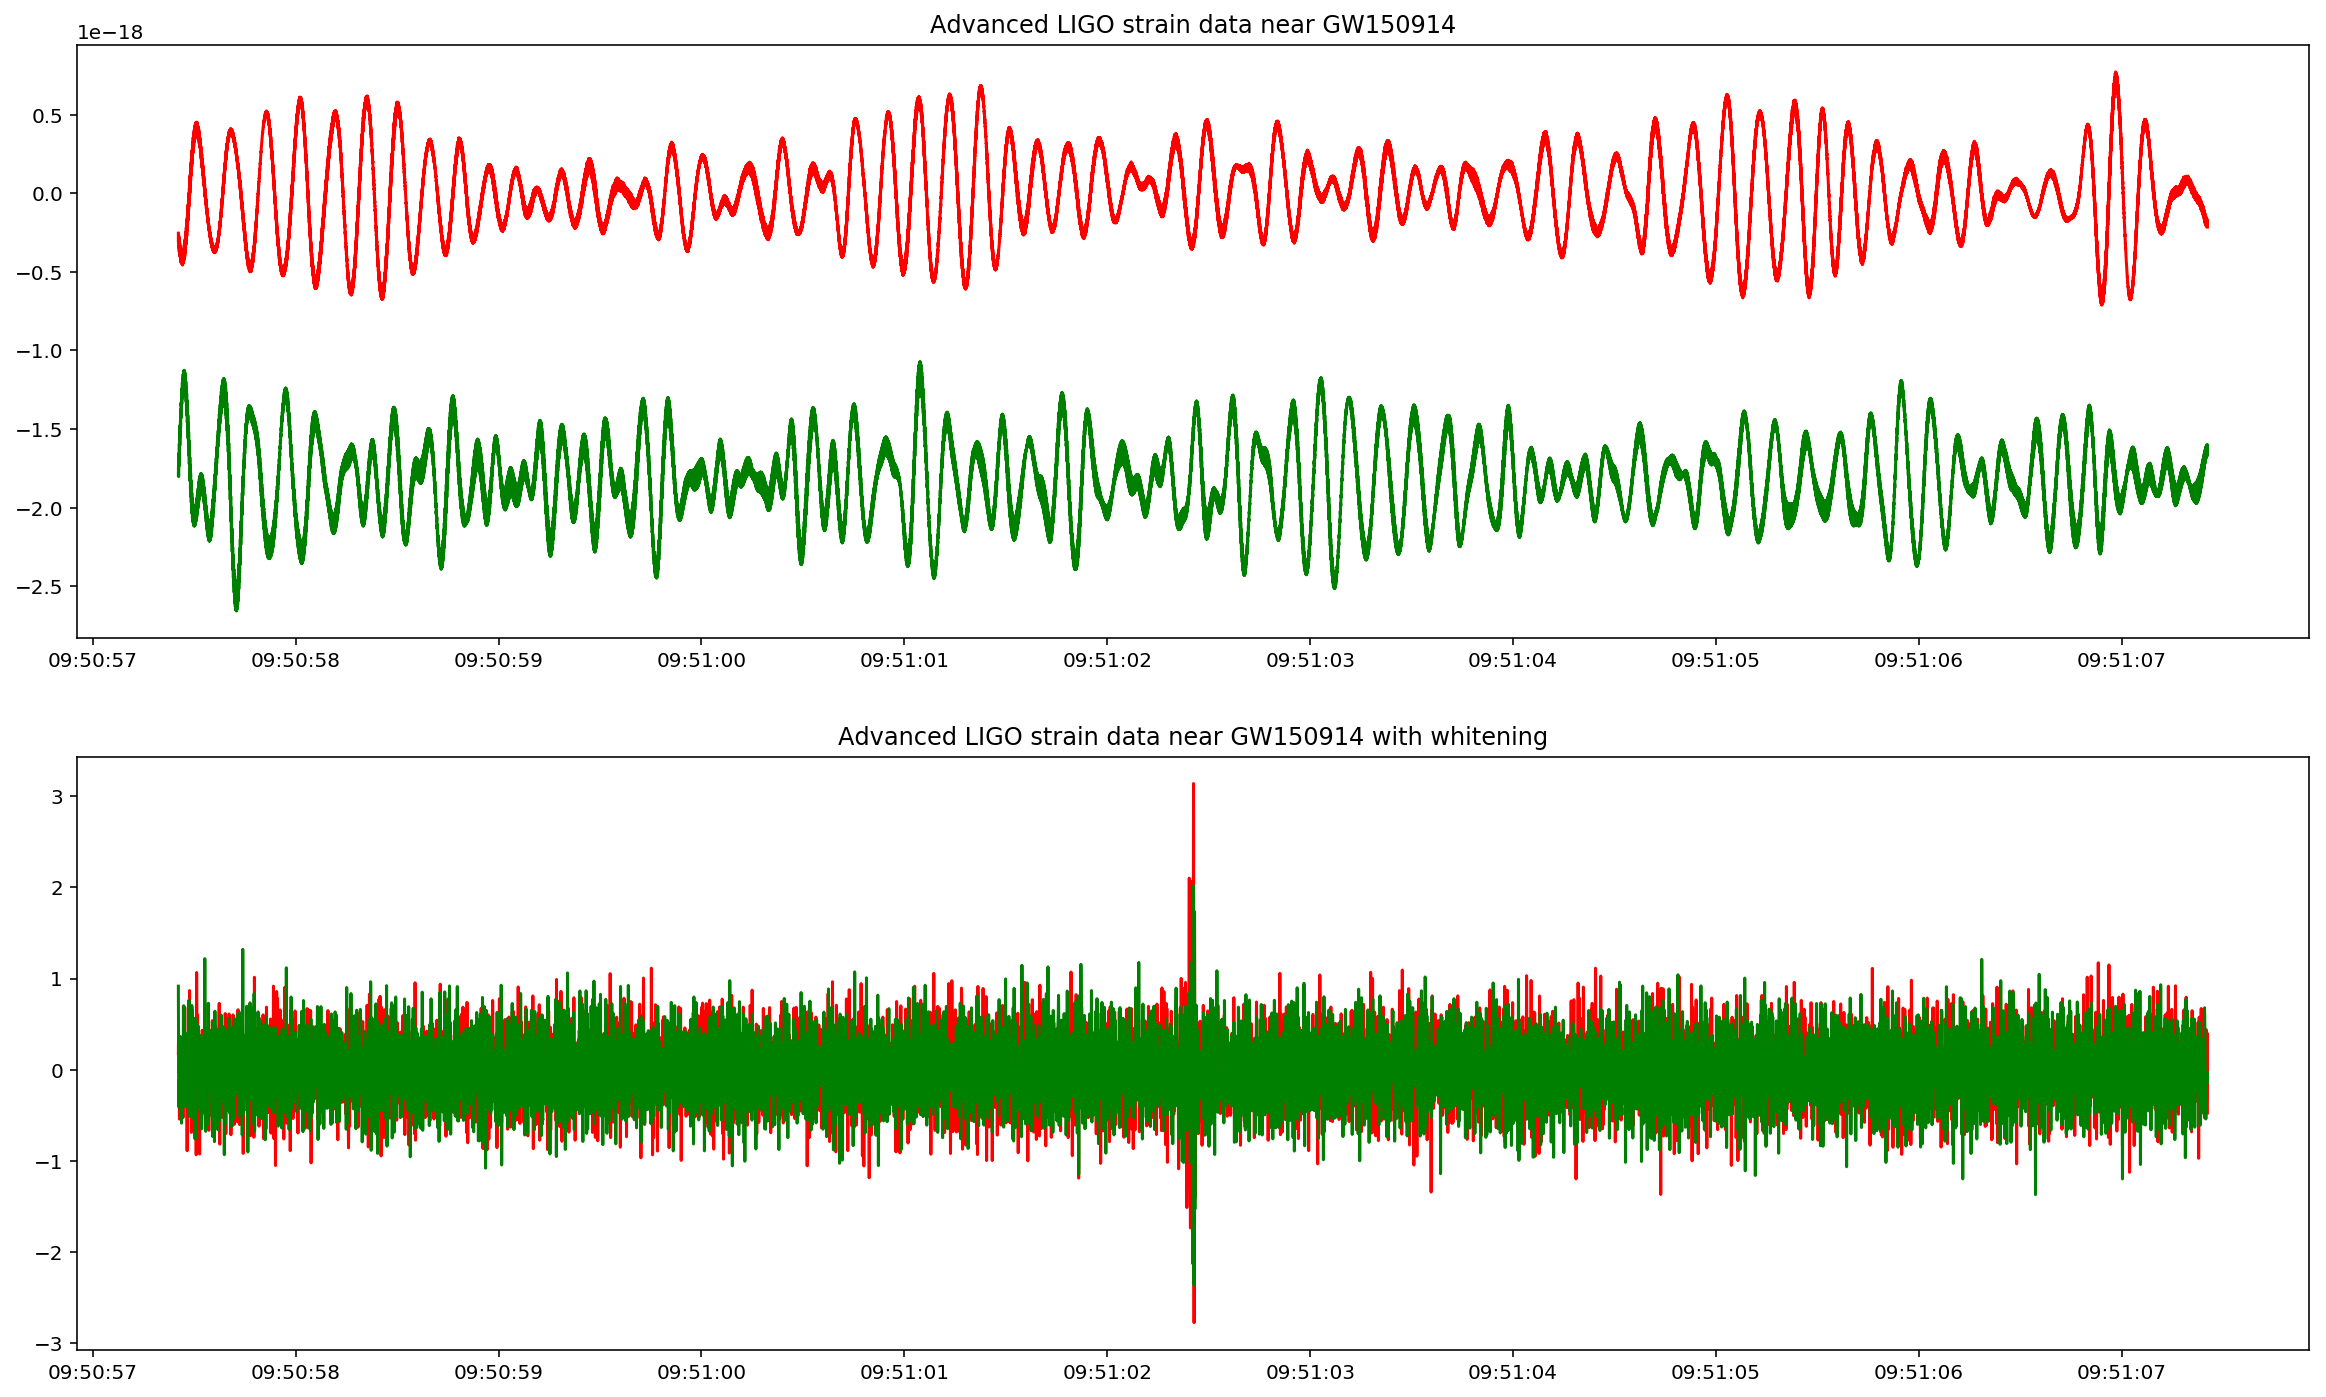

In [74]:
# plot +- 5 seconds around the event:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
tevent = pd.to_datetime(tevent, unit='s', origin=pd.Timestamp('1980-01-06'))
deltat = 5.                     # seconds around the event
deltat = pd.Timedelta(seconds=deltat)
# index into the strain time series for this time interval:
S2_windowed = S2[(S2['time'] > tevent-deltat) & (S2['time'] < tevent+deltat)]

fig, axes = plt.subplots(figsize=(20,12), nrows=2, ncols=1)
axes[0].plot(S2_windowed['time'], S2_windowed['strain_H1'],'r',label='H1 strain')
axes[0].plot(S2_windowed['time'], S2_windowed['strain_L1'],'g',label='L1 strain')
#axes[0].set_xlim([date])
#axes[0].set_ylim([-4,4])
axes[0].set_title('Advanced LIGO strain data near GW150914')
axes[1].plot(S2_windowed['time'], S2_windowed['strain_H1_whitenbp'],'r',label='whitened_H1 strain')
axes[1].plot(S2_windowed['time'], S2_windowed['strain_L1_whitenbp'],'g',label='Whitened_L1 strain')
#axes[1].set_xlim([-0.1,0.05])
#axes[1].set_ylim([-4,4])
#plt.plot(time_L1[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
#plt.xlabel('time (s) since '+str(tevent))
#plt.ylabel('strain')
#plt.legend(loc='lower right')
axes[1].set_title('Advanced LIGO strain data near GW150914 with whitening')

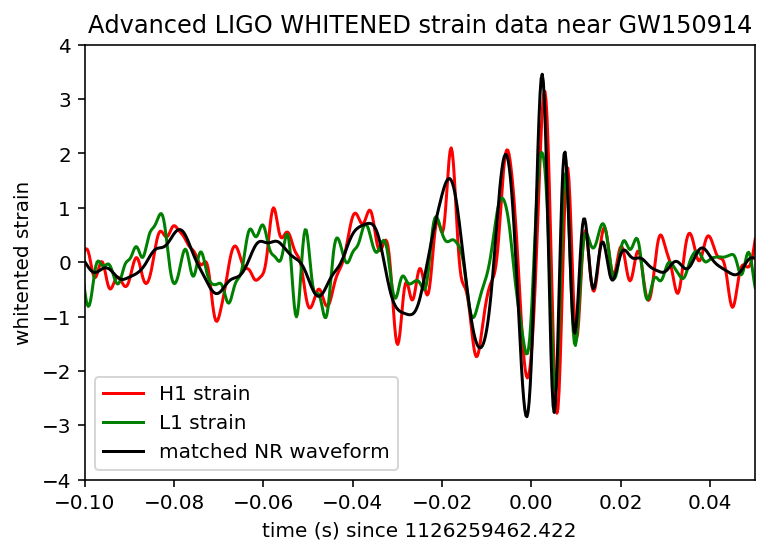

In [76]:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.  
plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_shift,'g',label='L1 strain')
plt.plot(NRtime+0.002,NR_H1_whitenbp,'k',label='matched NR waveform')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

## Spectrograms

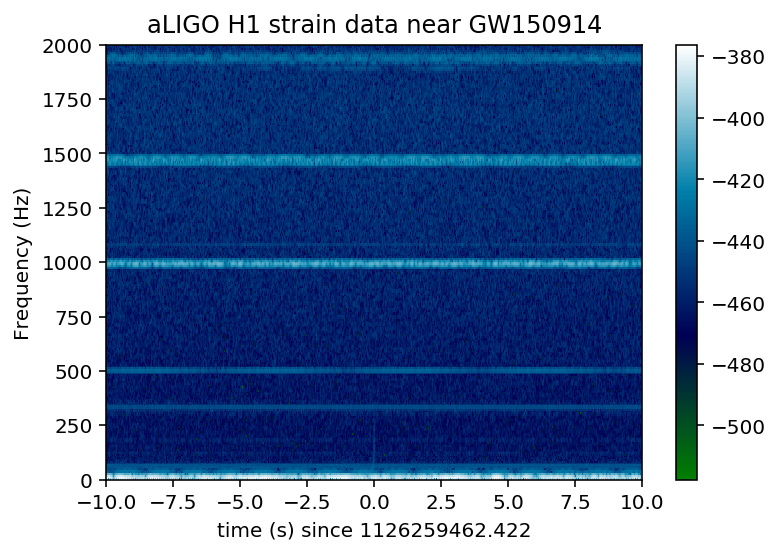

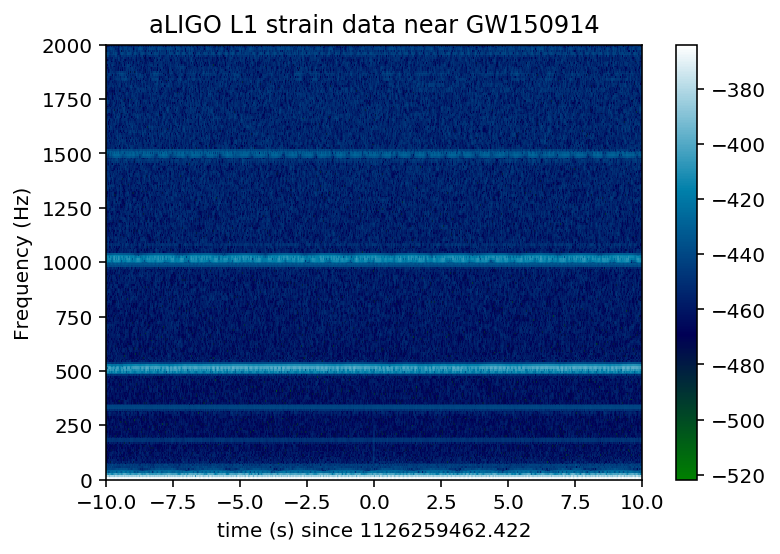

In [9]:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.0                   # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

# pick a shorter FTT time interval, like 1/8 of a second:
# NFFT needed to be made an integer
NFFT = int(fs/8)
# and with a lot of overlap, to resolve short-time features:
NOVL = NFFT*15/16
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# the right colormap is all-important! See:
# http://matplotlib.org/examples/color/colormaps_reference.html
# viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
#spec_cmap='viridis'
spec_cmap='ocean'

# Plot the H1 spectrogram:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO H1 strain data near GW150914')
plt.savefig('GW150914_H1_spectrogram.png')

# Plot the L1 spectrogram:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO L1 strain data near GW150914')
plt.savefig('GW150914_L1_spectrogram.png')

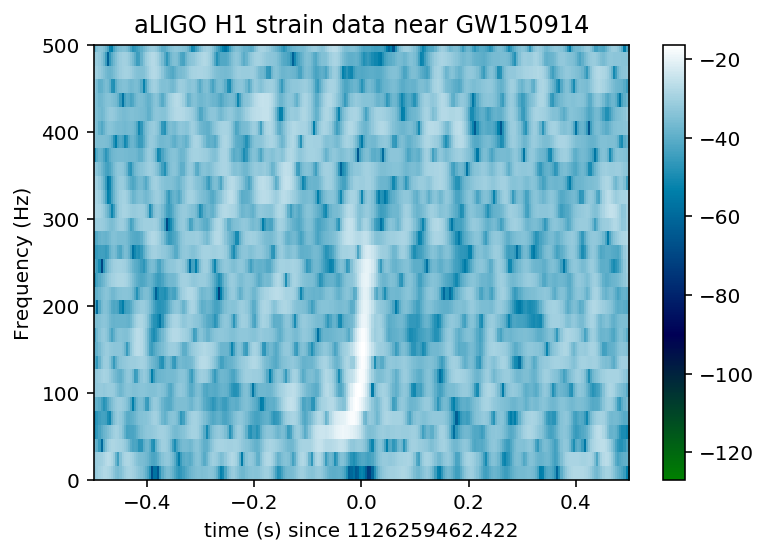

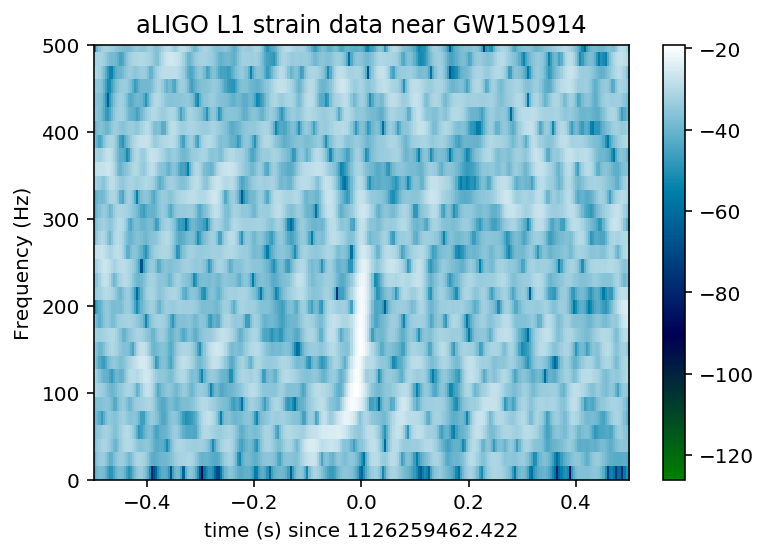

In [10]:
#  plot the whitened data, zooming in on the signal region:
tevent = 1126259462.422          # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.0                     # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16)
# and with a lot of overlap, to resolve short-time features:
NOVL = NFFT*15/16
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# Plot the H1 whitened spectrogram around the signal
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO H1 strain data near GW150914')
plt.savefig('GW150914_H1_spectrogram_whitened.png')

# Plot the L1 whitened spectrogram around the signal
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_L1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO L1 strain data near GW150914')
plt.savefig('GW150914_L1_spectrogram_whitened.png')

## Project Objective

* Identify the gravitational wave (GW) by an arma model with kalman filtering or more FFT
* Widen time window and still identify GW
* Try it on other reported GWs